##GANs for Synthetic Data Generation

We implement a Generative Adversarial Network (GAN) in the Keras functional API. In this module we will pay attention to:

- Implementing the GAN architecture in Keras.
- Training our model.
- Using our model to generate synthetic data.

Note that we will not spend time tuning hyper-parameters: The purpose is to show how different techniques can be implemented in Keras, not to solve particular data science problems as optimally as possible. Obviously, most techniques include hyper-parameters that need to be tuned for optimal performance.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri May  7 12:31:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We import required libraries.

In [2]:
from keras.datasets.mnist import load_data
from keras import Model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Input,Dense,Conv2D,Flatten,Dropout,LeakyReLU,Reshape,Conv2DTranspose
from keras.utils.vis_utils import model_to_dot
from statistics import mean

from matplotlib import pyplot

import numpy as np
import numpy.random as rng


As in the denoising auto-encoder module, we will be working with the MNIST data. These are 28x28 greyscale images of handwritten digits (0-9). The classes are the digit. 

This data is included in Keras.datasets library, so it is easy to load. We will expand the image dimension so that we have a single channel (as it is greyscale we have only one channel), and normalize the pixel values to real numbers between 0 and 1.

We will only work with the training data, and so will create a function that pre-processes and returns that. If you want to look at the data, examine the code in module 2.4, as this provides functions for viewing the MNIST images with their class labels.

In [3]:
def get_data ():
  # load the images into memory
  (trainX, trainy), (testX, testy) = load_data()
  # We will only really work with the trainX data.
  # Let's expand it to add channel dimension
  X = np.expand_dims(trainX, axis=-1)
  # Convert from unsigned ints to floats and scale to between 0 and 1.
  X = X.astype('float32')
  X = X / 255.0
  return X

We call our get data function.

In [4]:
X=get_data()

11493376/11490434 [==============================] - 0s 0us/step


We want our discriminator to train on batches of real and fake images, learning to distinguish between the two. So we need a function to grab a set of real images from our MNIST image data.

In [5]:
# select real samples
def select_real_images(dataset, n_samples):
    # choose random instances
    indices = rng.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[indices]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

Now let us define a function to create our discriminator model. We will also compile it within the function, so if you want to play around with the optimizer change the code in here.

In [22]:
def get_discriminator(in_shape=(28,28,1)):
  # Define Model
  # This is a basic binary classification CNN
  inputs=Input(in_shape)
  
  conv1=Conv2D(128, 5, strides=2, padding='same')(inputs)
  leak1=LeakyReLU(alpha=.2)(conv1)
  drop1=Dropout(.4)(leak1)
  
  conv2=Conv2D(64, 5, strides=2, padding='same')(drop1)
  leak2=LeakyReLU(alpha=.2)(conv2)
  drop2=Dropout(.4)(leak2)
  
  flat=Flatten()(drop2)
  outputs=Dense(1,activation='sigmoid')(flat)
  
  # Create Model
  model=Model(inputs=inputs,outputs=outputs)
  
  # Compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

If you wish, run the following code block to create an instance of the discriminator model in order to view a summary.

Note we will create the discriminator instance we use for the problem in a later code block.

In [24]:
# Get the discriminator
discriminator = get_discriminator()
# View a summary of the discriminator
discriminator.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 128)       3328      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 64)          204864    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 7, 64)          0   

In [30]:
def get_generator(noise_dim=100):
    # Define the generator model
    inputs=Input((noise_dim,))
    
    # Create a basis for 7x7 image
    # We are using the noise to generate 128 high level 'feature maps' in a 7x7 space
    n = 128 * 7 * 7
    dense = Dense(n)(inputs)
    leak1 = LeakyReLU(alpha=0.2)(dense)
    reshape = Reshape((7, 7, 128))(leak1)
    
    # Now we extract lower level features...
    # Upsample to 14x14
    conv_tran1 = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(reshape)
    leak2=LeakyReLU(alpha=0.2)(conv_tran1)
    
    # Now we extract even lower level features...
    # Upsample to 28x28
    conv_tran2 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(leak2)
    leak3 = LeakyReLU(alpha=0.2)(conv_tran2)
    
    # Finally we put togeather our pixel values for the synthetic image
    outputs = Conv2D(1, (7,7), activation='sigmoid', padding='same')(leak3)
    
    # Create the model and return it
    model=Model(inputs=inputs,outputs=outputs)
    return model

If you wish, run the following code block to create an instance of the generator model in order to view a summary. You can change the dimension of the noise vector if you like.

Note we will create the generator instance we use for the problem in a later code block.

In [31]:
# Specify the dimension of the noise vector
noise_dim = 100
# Get the generator model
generator = get_generator(noise_dim)
# Summarize the model
generator.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_11 (Dense)             (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 128)       147584    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 64)        737

Obviously we want to generate this noise from something simple so that we can sample from the same distribution later. So we use simple independent Gaussian noise.

We create a function that will generate as many of these noise vectors as we wish.

In [32]:
# Generate independent Gaussian noise as input for the generator
def generate_input_noise(noise_dim, num_vectors):
    # Generate independent Gaussian noise
    noise_input = rng.standard_normal(noise_dim * num_vectors)
    # Reshape into a 2d array
    noise_input = noise_input.reshape(num_vectors, noise_dim)
    return noise_input

Now we create a function to generate fake images from the noise vectors using the generator. We will also get this function to return labels indicating that the images are fake (we represent this by 0).

In [34]:
# Generate n fake images using the generator
def generate_fake_images(generator, noise_dim, n_images):
    # Generate noise vectors
    noise = generate_input_noise(noise_dim, n_images)
    # Use generator to create fake images from noise vectors
    fakes = generator.predict(noise)
    # create 'fake' class labels (0)
    labels = np.zeros((n_images, 1))
    return fakes, labels

Let's also create a function that plot's fake images created by the generator so we look at them.

In [35]:
# Plot fake images created by generator from random noise
def plot_generated_images(generator,noise_dim=100,n_images=25):
    # Create the fake images (we don't need the labels here)
    X, _ = generate_fake_images(generator, noise_dim, n_images)
    # Plot the fake images
    for i in range(n_images):
        pyplot.subplot(5, 5, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    pyplot.show()

Now we will create a function to make our GAN. This will involve putting the discriminator and generator together into a single model. We will also want to be able to treat them as individual models as well, so we will return (1) the discriminator, (2) the generator, and (3) the combined GAN.

Note that we will make the weights in the discriminator non-trainable in the combined GAN model. This means that when we train the GAN we are actually only optimizing the weights in the generator. I discuss this further after we define the train function below.

Once again, we will compile the model in the function. This is the optimizer that will be used for training the generator (because of the above). If you want to play around with the optimizer change the code inside the function.

In [36]:
# Create the discriminator, generator and GAN networks.
# Compile networks requiring compilation within function.
def get_gan_models(noise_dim=100):
    # Create the discriminator (compiled internally)
    discriminator = get_discriminator()
    # Create the generator
    generator = get_generator(noise_dim)
    
    # Make weights in the discriminator not trainable
    discriminator.trainable = False
    
    # Make GAN
    inputs = Input((noise_dim,))
    gan = Model(inputs,discriminator(generator(inputs)))
    
    # Compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    
    return discriminator,generator,gan

Now let's finally get our networks. If you want to change the noise dimension we work with in the problem, change the value here.

In [37]:
noise_dim=100
discriminator,generator,gan=get_gan_models(noise_dim)

We are going to code a manual implementation of the training loop. This is so we can implement appropriate training for the discriminater and generator.

Note we do not use validation data, and such data makes little sense in this context.

In [38]:
# Train the generator and discriminator
def train(
    gan, 
    generator,
    discriminator,
    dataset, 
    noise_dim=100, 
    epochs=100, 
    batch_size=256
):
    # We keep the amount of work done per 'epoch' matching
    # the dataset size, though in reality this is quite arbitrary.
    batches_per_epoch = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    # Iterate through desired number of epochs
    for i in range(epochs):
        # Iterate through batches
        d_loss_list = []
        g_loss_list = []
        for j in range(batches_per_epoch):
            # Train the discriminator            
            # Get randomly selected real images
            X_real, Y_real = select_real_images(dataset, half_batch)
            # Generate fake images
            X_fake, Y_fake = generate_fake_images(generator, noise_dim, half_batch)
            # Create training set for the discriminator
            X, Y = np.vstack((X_real, X_fake)), np.vstack((Y_real, Y_fake))
            # Update discriminator model weights
            d_loss, _ = discriminator.train_on_batch(X, Y)
            d_loss_list.append(d_loss) 
            
            # Train the generator
            # Prepare input noise
            X_gan = generate_input_noise(noise_dim, batch_size)
            # Create inverted labels for the fake samples
            # This is because the GAN/generator is trying to get the discriminator
            # to classify these fake images as real.
            Y_gan = np.ones((batch_size, 1))
            # Update the generator weights via the discriminator's error
            # Remember the discriminator's weights are fixed in the GAN,
            # so these will not be adjusted.
            g_loss = gan.train_on_batch(X_gan, Y_gan)
            g_loss_list.append(g_loss)

            
            # Give information about loss on this batch
            # print("Epoch: {} Batch: {}/{} Disc. Loss: {:06.5f} Gen. Loss: {:06.5f}".format(i+1, j+1,batches_per_epoch, d_loss, g_loss))

    # Epoch performance
    print('Epoch: {}, Discriminator loss mean:{:06.5f}, Generator loss mean:{:06.5f}'.format(i+1,mean(d_loss_list),mean(g_loss_list)))

Making the discriminator not trainable is a clever trick in the Keras API.

The trainable property impacts the model after it is compiled. The discriminator model was compiled with trainable layers, therefore the model weights in those layers will be updated when the standalone model is updated via calls to the train_on_batch() function.

The discriminator model was then marked as not trainable, added to the GAN model, and compiled. In this model, the model weights of the discriminator model are not trainable and cannot be changed when the GAN model is updated via calls to the train_on_batch() function. This change in the trainable property does not impact the training of standalone discriminator model.

This behavior is described in the Keras API documentation here:

[How can I “freeze” Keras layers?](https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers)

In [ ]:
train(gan,generator,discriminator,X)

Streaming output truncated to the last 5000 lines.
Epoch: 52 Batch: 138/234 Disc. Loss: 0.68715 Gen. Loss: 0.71956
Epoch: 52 Batch: 139/234 Disc. Loss: 0.68201 Gen. Loss: 0.72250
Epoch: 52 Batch: 140/234 Disc. Loss: 0.67129 Gen. Loss: 0.81704
Epoch: 52 Batch: 141/234 Disc. Loss: 0.67055 Gen. Loss: 0.71204
Epoch: 52 Batch: 142/234 Disc. Loss: 0.65571 Gen. Loss: 0.70691
Epoch: 52 Batch: 143/234 Disc. Loss: 0.69764 Gen. Loss: 0.80410
Epoch: 52 Batch: 144/234 Disc. Loss: 0.65933 Gen. Loss: 0.76780
Epoch: 52 Batch: 145/234 Disc. Loss: 0.70101 Gen. Loss: 0.73827
Epoch: 52 Batch: 146/234 Disc. Loss: 0.69964 Gen. Loss: 0.80151
Epoch: 52 Batch: 147/234 Disc. Loss: 0.67474 Gen. Loss: 0.77756
Epoch: 52 Batch: 148/234 Disc. Loss: 0.67065 Gen. Loss: 0.79401
Epoch: 52 Batch: 149/234 Disc. Loss: 0.66234 Gen. Loss: 0.76680
Epoch: 52 Batch: 150/234 Disc. Loss: 0.68362 Gen. Loss: 0.68454
Epoch: 52 Batch: 151/234 Disc. Loss: 0.67236 Gen. Loss: 0.81200
Epoch: 52 Batch: 152/234 Disc. Loss: 0.67334 Gen. Los

You may see a warning:

UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'

Don't worry about this - it is actually doing exactly what we want.

When you set certain weights to trainable or untrainable (as we did in the line: discriminator.trainable = False) this only takes effect once you compile the model. We compiled the discriminator model before this call, so its weights are still trainable when we train *the discriminator model* by batch.

But the discriminator model is also a *sub-model* of our complete GAN. And the GAN model was compiled *after* we set the discriminator weights to untrainable. So the discriminator weights will not be trained when we train the GAN model by batch. Neat huh?

The warning is Keras thinking we have been too clever by half and are possibly making a mistake somewhere. But we aren't. :)

You could get rid of the warning by setting the discriminator trainability to True and False and then recompiling models within the training loop. But that would be a lot more work...

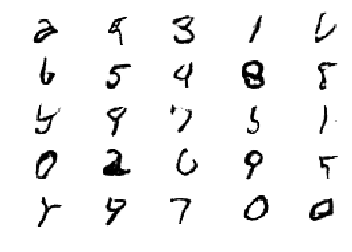

In [ ]:
plot_generated_images(generator,100,25)

1. You might be surprised that there are images of all sorts of digits, thinking that it looks easiest for the generator to fake certain digits like '0'. But for any reasonably balanced multi-class problem, the generator cannot focus on simulating the simplest class - otherwise the discriminator will simply 'abandon' that class as typically fake. 

2. You might be surprised that the loss functions oscillate. But remember the two networks are in competition!

3. We can generate synthetic data from the GAN. But unlike the variational auto-encoder, in this naive implementation we cannot generate synthetic data of certain classes (similar to known images).